# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import json

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import *
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

/home/pqlza/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-22 19:49:02.744785: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 19:49:02.773078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-22 19:49:03.675067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 19:49:03.678957: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 19:49:03.679081: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = 150
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-04-22 19:49:03.686218: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 19:49:03.686385: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 19:49:03.686448: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-04-22 19:49:06.230456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


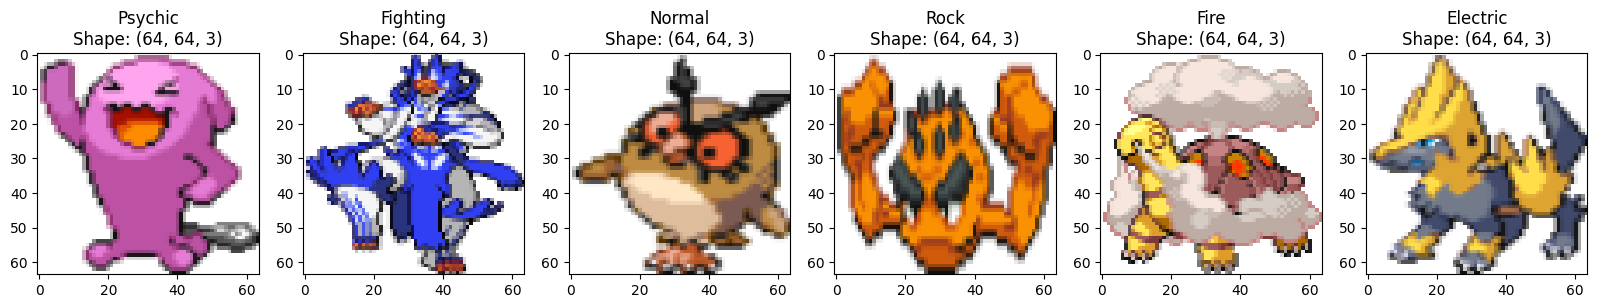

2024-04-22 19:49:06.768711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 64, 64, 3)
(32, 18)


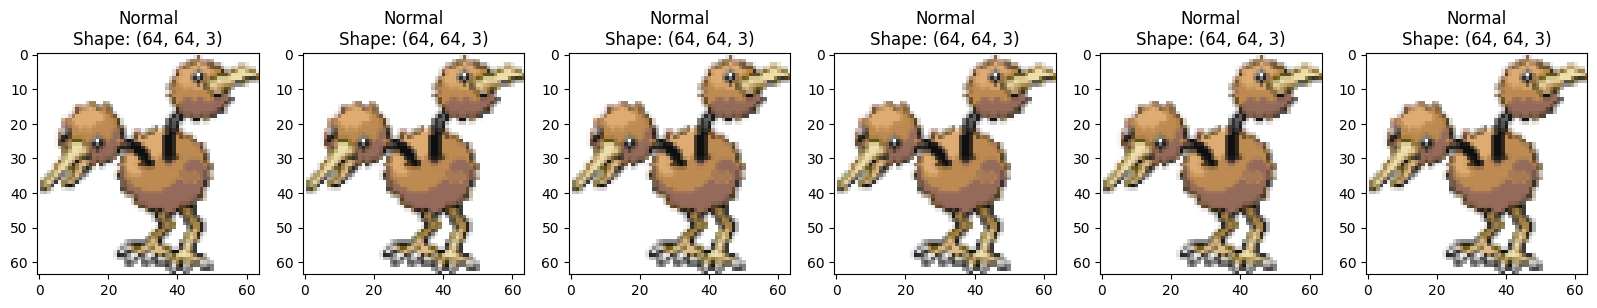

2024-04-22 19:49:07.239471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-22 19:49:07.240470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(512).batch(BATCH_SIZE)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    label_example = label[0]
    visualize.plot_images_batch(dataset_tf=dataset_example)

In [7]:
label_example

<tf.Tensor: shape=(18,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0.], dtype=float32)>

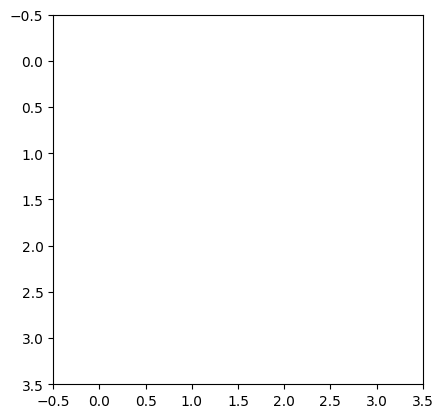

In [8]:
# get the image and the label
for img, label in dataset_example.take(1):
    img_example = img[0]
    label_example = label[0]
    break

# get the coordinates of the bottom right corner of the pokemon
x = 60
y = 60
w = 30
h = 30

# Slice the tensor to get the pixel values within the background area
img_white_area = img_example[y : y + h, x : x + w, :]

plt.imshow(img_white_area)

In [9]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

Epoch 1/100


2024-04-22 19:49:15.159515: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-04-22 19:49:17.156153: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - loss: 0.9661
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.7430
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.5710
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.3296
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.3303
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.1890
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.1546
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.2766
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.2072
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.2145Epoch 10: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 22.45it/s]


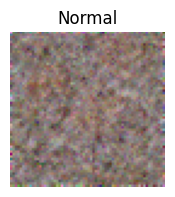

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 790ms/step - loss: 0.2019
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1787
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.3419
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.2109
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.1547
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.2254
Epoch 16/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.3119
Epoch 17/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1377
Epoch 18/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0814
Epoch 19/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1461
Epoch 20/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.1654Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 24.40it/s]


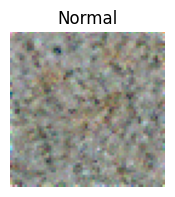

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 749ms/step - loss: 0.1557
Epoch 21/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.1832
Epoch 22/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1424
Epoch 23/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.1627
Epoch 24/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0827
Epoch 25/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1909
Epoch 26/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.1457
Epoch 27/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1081
Epoch 28/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.1424
Epoch 29/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1393
Epoch 30/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.1593Epoch 30: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 24.04it/s]


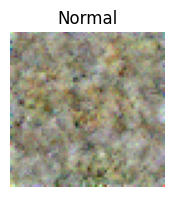

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 760ms/step - loss: 0.1499
Epoch 31/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1746
Epoch 32/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0725
Epoch 33/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.1645
Epoch 34/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0744
Epoch 35/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0825
Epoch 36/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.1306
Epoch 37/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0823
Epoch 38/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1574
Epoch 39/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1414
Epoch 40/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.1094Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 24.14it/s]


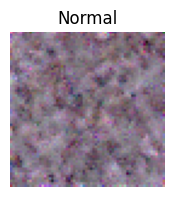

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 758ms/step - loss: 0.1029
Epoch 41/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0872
Epoch 42/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0691
Epoch 43/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0994
Epoch 44/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.1926
Epoch 45/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1420
Epoch 46/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0990
Epoch 47/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0900
Epoch 48/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0543
Epoch 49/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1519
Epoch 50/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.1292Epoch 50: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.94it/s]


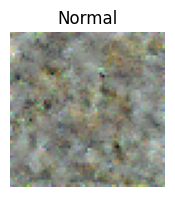

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 760ms/step - loss: 0.1216
Epoch 51/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1074
Epoch 52/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.1263
Epoch 53/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1407
Epoch 54/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0611
Epoch 55/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0645
Epoch 56/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0593
Epoch 57/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0600
Epoch 58/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.1105
Epoch 59/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0787
Epoch 60/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0829Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.56it/s]


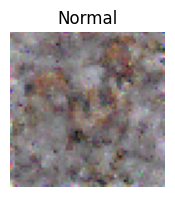

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 768ms/step - loss: 0.0780
Epoch 61/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0861
Epoch 62/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0820
Epoch 63/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0828
Epoch 64/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0738
Epoch 65/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1182
Epoch 66/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.2335
Epoch 67/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1329
Epoch 68/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1259
Epoch 69/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1770
Epoch 70/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.1232Epoch 70: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.32it/s]


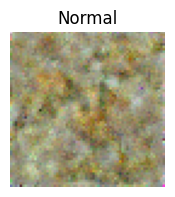

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 773ms/step - loss: 0.1159
Epoch 71/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0867
Epoch 72/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.0782
Epoch 73/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.0708
Epoch 74/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - loss: 0.0454
Epoch 75/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0775
Epoch 76/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.0508
Epoch 77/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.0571
Epoch 78/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - loss: 0.0570
Epoch 79/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - loss: 0.0482
Epoch 80/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.0786Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 21.68it/s]


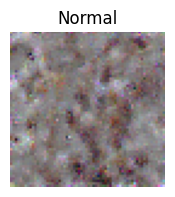

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 811ms/step - loss: 0.0740
Epoch 81/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0529
Epoch 82/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0755
Epoch 83/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.0628
Epoch 84/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0630
Epoch 85/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0786
Epoch 86/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0566
Epoch 87/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0426
Epoch 88/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0418
Epoch 89/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0820
Epoch 90/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.1710Epoch 90: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.85it/s]


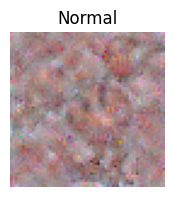

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 766ms/step - loss: 0.1610
Epoch 91/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.1668
Epoch 92/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.1519
Epoch 93/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0938
Epoch 94/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1032
Epoch 95/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0743
Epoch 96/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0977
Epoch 97/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0718
Epoch 98/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0427
Epoch 99/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0411
Epoch 100/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0801Epoch 100: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.45it/s]


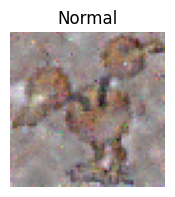

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 768ms/step - loss: 0.0754


In [10]:
tf.config.run_functions_eagerly(True)  # to debug the model
# model.fit(
#     dataset_example,
#     epochs=EPOCHS,
#     callbacks=[PlottingCallback(model, 6), DiffusionCallback(model, 20, "Electric")],
# )
str_label_example = onehot_to_string(label_example)
model.fit(
    dataset_example,
    epochs=EPOCHS,
    callbacks=[DiffusionCallback(model, 10, str_label_example)],
)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0739
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0998
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0550
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0394
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0592
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0780
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1239
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.1275
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0519
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0915
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0787
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0639
Epoch 13/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0317
Epoch 14/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0301
Epoch 15/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 

Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 24.44it/s]


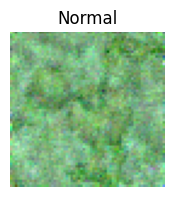

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 750ms/step - loss: 0.0753
Epoch 21/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0730
Epoch 22/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0568
Epoch 23/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0373
Epoch 24/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0279
Epoch 25/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0697
Epoch 26/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0272
Epoch 27/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.2520
Epoch 28/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0495
Epoch 29/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0579
Epoch 30/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - loss: 0.1084
Epoch 31/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1098
Epoch 32/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0723
Epoch 33/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0374
Epoch 34/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314

Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 24.17it/s]


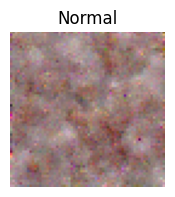

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - loss: 0.0543
Epoch 41/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0417
Epoch 42/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0651
Epoch 43/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0246
Epoch 44/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0395
Epoch 45/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0251
Epoch 46/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0397
Epoch 47/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0810
Epoch 48/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0845
Epoch 49/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0646
Epoch 50/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0651
Epoch 51/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0343
Epoch 52/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0345
Epoch 53/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0954
Epoch 54/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321

Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.79it/s]


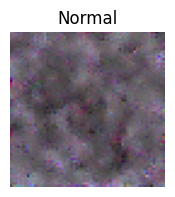

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 762ms/step - loss: 0.0709
Epoch 61/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1614
Epoch 62/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1220
Epoch 63/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1343
Epoch 64/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1317
Epoch 65/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0943
Epoch 66/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0795
Epoch 67/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0459
Epoch 68/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0404
Epoch 69/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0756
Epoch 70/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0690
Epoch 71/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0340
Epoch 72/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0842
Epoch 73/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0344
Epoch 74/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317

Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 24.00it/s]


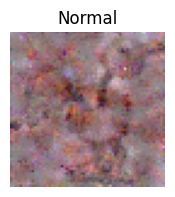

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 759ms/step - loss: 0.0384
Epoch 81/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0252
Epoch 82/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0191
Epoch 83/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0276
Epoch 84/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0557
Epoch 85/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0539
Epoch 86/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0275
Epoch 87/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0328
Epoch 88/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0342
Epoch 89/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0254
Epoch 90/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0370
Epoch 91/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0571
Epoch 92/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0262
Epoch 93/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0410
Epoch 94/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315

Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.90it/s]


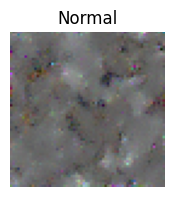

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 764ms/step - loss: 0.0202
Epoch 101/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0204
Epoch 102/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0563
Epoch 103/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0274
Epoch 104/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0439
Epoch 105/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0355
Epoch 106/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0845
Epoch 107/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0321
Epoch 108/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0321
Epoch 109/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0242
Epoch 110/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0446
Epoch 111/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0240
Epoch 112/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0273
Epoch 113/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0137
Epoch 114/200
16/16 ━━━━━━━━━━━━━

Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.31it/s]


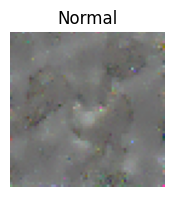

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 778ms/step - loss: 0.0152
Epoch 121/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0170
Epoch 122/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0177
Epoch 123/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0253
Epoch 124/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0395
Epoch 125/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0252
Epoch 126/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0214
Epoch 127/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0664
Epoch 128/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0298
Epoch 129/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.0221
Epoch 130/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0367
Epoch 131/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0388
Epoch 132/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0780
Epoch 133/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0744
Epoch 134/200
16/16 ━━━━━━━━━━━━━

Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.48it/s]


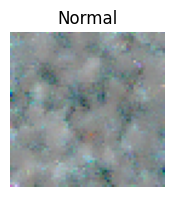

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 771ms/step - loss: 0.0414
Epoch 141/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0193
Epoch 142/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0222
Epoch 143/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0254
Epoch 144/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0736
Epoch 145/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0755
Epoch 146/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0330
Epoch 147/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1092
Epoch 148/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1693
Epoch 149/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0654
Epoch 150/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0773
Epoch 151/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0489
Epoch 152/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0239
Epoch 153/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0753
Epoch 154/200
16/16 ━━━━━━━━━━━━━

Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.76it/s]


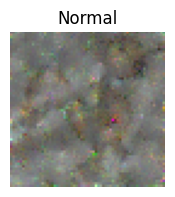

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 766ms/step - loss: 0.0253
Epoch 161/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0145
Epoch 162/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0191
Epoch 163/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0217
Epoch 164/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0611
Epoch 165/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0328
Epoch 166/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0205
Epoch 167/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0178
Epoch 168/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0381
Epoch 169/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0468
Epoch 170/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0536
Epoch 171/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1156
Epoch 172/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1310
Epoch 173/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.1118
Epoch 174/200
16/16 ━━━━━━━━━━━━━

Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.76it/s]


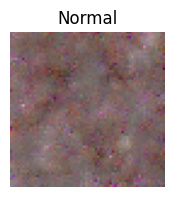

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 767ms/step - loss: 0.0294
Epoch 181/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0576
Epoch 182/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0808
Epoch 183/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1526
Epoch 184/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0513
Epoch 185/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0636
Epoch 186/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0424
Epoch 187/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0451
Epoch 188/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0527
Epoch 189/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0318
Epoch 190/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0218
Epoch 191/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0181
Epoch 192/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0331
Epoch 193/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0153
Epoch 194/200
16/16 ━━━━━━━━━━━━━

Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 22.17it/s]


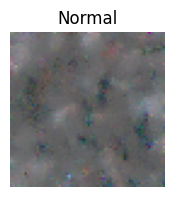

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 803ms/step - loss: 0.0236


In [11]:
model.fit(
    dataset_example,
    epochs=200,
    callbacks=[DiffusionCallback(model, 20, str_label_example)],
)

In [14]:
# model.fit(
#     dataset_example,
#     epochs=200,
#     callbacks=[DiffusionCallback(model, 10, str_label_example)],
# )

Generating sample 1/1


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 22.99it/s]


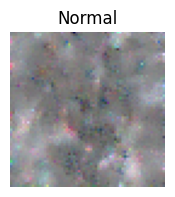

In [12]:
model.plot_samples(1, str_label_example)

Generating sample 1/3


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 22.82it/s]


Generating sample 2/3


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 22.83it/s]


Generating sample 3/3


Sampling sprite: 100%|██████████| 149/149 [00:06<00:00, 23.23it/s]


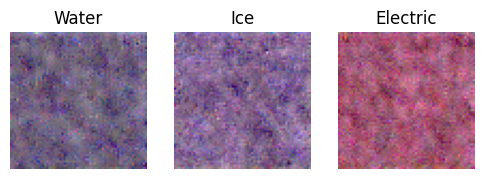

In [13]:
model.plot_samples(3)

In [ ]:
# df = preprocess.load_csv("../../dataset/pokedex.csv")
# data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
# data_dict = preprocess.dataset_dict(data_path, df)
# dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
# label_mappping = preprocess.create_label_mapping(df)

# def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
#     """Generates a random embedding (label)

#     :param num_classes: The number of classes
#     """

#     em = np.zeros(num_classes)
#     em[np.where(label_example[0] == 1)[0][0]] = 1
#     return em


# generate_em()
# plotter.onehot_to_string(generate_em(), label_mappping)